In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
'''读取数据'''
data_path = './concatData.xlsx'
CN_MCI_Data = pd.read_excel(data_path,sheet_name="CN_MCI")

In [3]:
CN_MCI_Data.columns

Index(['IID', 'DX', 'status', 'APOE4', 'PTGENDER', 'PTMARRY', 'AGE',
       'PTEDUCAT', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
       'RAVLTimmediate', 'RAVLTlearning', 'RAVLTforgetting',
       'RAVLTpercforgetting', 'LDELTOTAL', 'TRABSCOR', 'FAQ', 'cg17750572',
       'cg01452847', 'cg13348062', 'cg18627235', 'cg15452204', 'cg01821149',
       'cg00884606', 'cg03354992', 'cg09173768', 'cg14515364', 'std.PRS',
       'cov_prs'],
      dtype='object')

In [12]:
Counter(CN_MCI_Data['status'])  

Counter({0: 209, 1: 345})

### 1、串联拼接

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning

# 忽略所有的 ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 假设你的数据已经准备好
# X = 特征矩阵
# y = 标签

# 定义模型
models = {
    'KNN': KNeighborsClassifier(n_neighbors=15),
    'Ridge': LogisticRegression(penalty='l2', solver='liblinear'),
    'Bayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'RF': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(),
    'GDBT': GradientBoostingClassifier()
}

# 定义评分标准
scoring = {
    'MCC': make_scorer(matthews_corrcoef),
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score)
}

# 交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=23)

In [145]:
from sklearn.neighbors import NearestNeighbors

def find_and_remove_danger_samples(X, y, k=5): 
    X = np.array(X)
    y = np.array(y)
    majority_class = max(set(y), key=list(y).count)
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    danger_indices = []
    for idx, x in enumerate(X):
        if y[idx] == majority_class:
            neighbors = neigh.kneighbors([x], return_distance=False)
            neighbor_labels = y[neighbors[0]]
            minority_count = np.sum(neighbor_labels != majority_class)
            if minority_count > k / 2:
                danger_indices.append(idx)
    X_cleaned = np.delete(X, danger_indices, axis=0)
    y_cleaned = np.delete(y, danger_indices, axis=0)
    
    return X_cleaned, y_cleaned

#### （1）临床数据

In [162]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE

clinic_X = CN_MCI_Data[['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT']]
clinic_y = CN_MCI_Data['status']

print('Original dataset shape %s' % Counter(clinic_y))


'''过采样'''
sm0 = BorderlineSMOTE(
    random_state=42,
    kind="borderline-1",
    sampling_strategy={0: 240, 1: 345 },
    k_neighbors=5, #确定邻居点的数量
    m_neighbors=10) #指定在合成样本生成过程中从近邻点中选择多少个样本作为参考
X_bdsmote0, y_bdsmote0 = sm0.fit_resample(clinic_X, clinic_y)
print('过采样 dataset shape %s' % Counter(y_bdsmote0))
# 合并为一个新的dataframe
y_bdsmote0 = pd.Series(y_bdsmote0,name="status")
data_bdsmote0 = pd.concat([X_bdsmote0, y_bdsmote0], axis=1)


'''欠采样'''
X_cleaned0, y_cleaned0 = find_and_remove_danger_samples(X_bdsmote0.values, data_bdsmote0["status"], k=100)
print(f"欠采样 dataset shape: {Counter(y_cleaned0)}")
# 合并为一个新的dataframe
X_bdknn0 = pd.DataFrame(X_cleaned0,columns=X_bdsmote0.columns)
y_bdknn0 = pd.Series(y_cleaned0,name="status")
data_bdknn0 = pd.concat([X_bdknn0, y_bdknn0], axis=1)

Original dataset shape Counter({1: 345, 0: 209})
过采样 dataset shape Counter({1: 345, 0: 240})
欠采样 dataset shape: Counter({1: 296, 0: 240})


In [163]:
clinic_ret = {}

# 标准化
standard_scaler0 = StandardScaler()
standard_scaler0.fit(X_bdknn0)
X_bdknn0 = standard_scaler0.transform(X_bdknn0)
X1 = pd.DataFrame(X_bdknn0,columns=[['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT']])


for name, model in models.items():    
    scores = cross_validate(model , X1, y_bdknn0, cv=cv, scoring=scoring)
    clinic_ret[name] = {
        'MCC': np.mean(scores['test_MCC']),
        'Accuracy': np.mean(scores['test_Accuracy']),
        'Precision': np.mean(scores['test_Precision']),
        'Recall': np.mean(scores['test_Recall']),
        'F1': np.mean(scores['test_F1'])
    }

# 输出结果
df_clinic = pd.DataFrame(clinic_ret).T
# print(df_clinic)

#### （2）临床数据+std.PRS

In [174]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE

# 标准化数据
prs_X = CN_MCI_Data[['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT', 
                  'cov_prs']]
prs_y = CN_MCI_Data['status']
print('Original dataset shape %s' % Counter(prs_y))


'''过采样'''
sm1 = BorderlineSMOTE(
    random_state=42,
    kind="borderline-1",
    sampling_strategy={0: 345, 1: 345 },
    k_neighbors=5, #确定邻居点的数量
    m_neighbors=10) #指定在合成样本生成过程中从近邻点中选择多少个样本作为参考
X_bdsmote1, y_bdsmote1 = sm1.fit_resample(prs_X, prs_y)
print('过采样 dataset shape %s' % Counter(y_bdsmote1))
# 合并为一个新的dataframe
y_bdsmote1 = pd.Series(y_bdsmote1,name="status")
data_bdsmote1 = pd.concat([X_bdsmote1, y_bdsmote1], axis=1)


'''欠采样'''
X_cleaned1, y_cleaned1 = find_and_remove_danger_samples(X_bdsmote1.values, data_bdsmote1["status"], k=100)
print(f"欠采样 dataset shape: {Counter(y_cleaned1)}")
# 合并为一个新的dataframe
X_bdknn1 = pd.DataFrame(X_cleaned1,columns=X_bdsmote1.columns)
y_bdknn1 = pd.Series(y_cleaned1,name="status")
data_bdknn1 = pd.concat([X_bdknn1, y_bdknn1], axis=1)

Original dataset shape Counter({1: 345, 0: 209})
过采样 dataset shape Counter({0: 345, 1: 345})
欠采样 dataset shape: Counter({1: 345, 0: 293})


In [175]:
clinic_prs_ret = {}

# 标准化
standard_scaler1 = StandardScaler()
standard_scaler1.fit(X_bdknn1)
X_bdknn1 = standard_scaler1.transform(X_bdknn1)
X2 = pd.DataFrame(X_bdknn1,columns=[['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT', 
                  'cov_prs']])


for name, model in models.items():    
    scores = cross_validate(model , X2, y_bdknn1, cv=cv, scoring=scoring)
    clinic_prs_ret[name] = {
        'MCC': np.mean(scores['test_MCC']),
        'Accuracy': np.mean(scores['test_Accuracy']),
        'Precision': np.mean(scores['test_Precision']),
        'Recall': np.mean(scores['test_Recall']),
        'F1': np.mean(scores['test_F1'])
    }

# 输出结果
df_clinic_prs = pd.DataFrame(clinic_prs_ret).T
# print(df_clinic_prs)

#### （3）临床数据+std.PRS+甲基化

In [176]:
cg_X = CN_MCI_Data[['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT', 
                  'cov_prs',
                  'cg17750572', 'cg01452847', 'cg13348062', 'cg18627235', 'cg15452204', 
                  'cg01821149', 'cg00884606', 'cg03354992', 'cg09173768', 'cg14515364']]
cg_y = CN_MCI_Data['status']
'''过采样'''
sm2 = BorderlineSMOTE(
    random_state=42,
    kind="borderline-1",
    sampling_strategy={0: 345, 1: 345 },
    k_neighbors=5, #确定邻居点的数量
    m_neighbors=10) #指定在合成样本生成过程中从近邻点中选择多少个样本作为参考
X_bdsmote2, y_bdsmote2 = sm2.fit_resample(cg_X, cg_y)
print('过采样 dataset shape %s' % Counter(y_bdsmote2))
# 合并为一个新的dataframe
y_bdsmote2 = pd.Series(y_bdsmote2,name="status")
data_bdsmote2 = pd.concat([X_bdsmote2, y_bdsmote2], axis=1)


'''欠采样'''
X_cleaned2, y_cleaned2 = find_and_remove_danger_samples(X_bdsmote2.values, data_bdsmote2["status"], k=100)
print(f"欠采样 dataset shape: {Counter(y_cleaned2)}")
# 合并为一个新的dataframe
X_bdknn2 = pd.DataFrame(X_cleaned2,columns=X_bdsmote2.columns)
y_bdknn2 = pd.Series(y_cleaned2,name="status")
data_bdknn2 = pd.concat([X_bdknn2, y_bdknn2], axis=1)

过采样 dataset shape Counter({0: 345, 1: 345})
欠采样 dataset shape: Counter({1: 345, 0: 295})


In [177]:
clinic_prs_methy_ret = {}

# # 标准化
standard_scaler3 = StandardScaler()
standard_scaler3.fit(X_bdknn2)
cg_bdknn_X = standard_scaler3.transform(X_bdknn2)
X3 = pd.DataFrame(cg_bdknn_X,columns=['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT', 
                  'cov_prs',
                  'cg17750572', 'cg01452847', 'cg13348062', 'cg18627235', 'cg15452204', 
                  'cg01821149', 'cg00884606', 'cg03354992', 'cg09173768', 'cg14515364'])
y3 = y_bdknn2


for name, model in models.items():
    scores = cross_validate(model, X3, y3, cv=cv, scoring=scoring)
    clinic_prs_methy_ret[name] = {
        'MCC': np.mean(scores['test_MCC']),
        'Accuracy': np.mean(scores['test_Accuracy']),
        'Precision': np.mean(scores['test_Precision']),
        'Recall': np.mean(scores['test_Recall']),
        'F1': np.mean(scores['test_F1'])
    }

# 输出结果
df_clinic_prs_methy = pd.DataFrame(clinic_prs_methy_ret).T
# print(df_clinic_prs_methy)

#### （4）验证集结果

In [178]:
print(df_clinic)
print(df_clinic_prs)
print(df_clinic_prs_methy)

               MCC  Accuracy  Precision    Recall        F1
KNN       0.155528  0.582122   0.622700  0.621695  0.621346
Ridge     0.193935  0.608186   0.620533  0.750113  0.678802
Bayes     0.192472  0.608238   0.623280  0.753446  0.680169
SVM       0.176599  0.600692   0.614328  0.753220  0.675267
RF        0.257588  0.632572   0.663514  0.682316  0.669414
AdaBoost  0.295793  0.649290   0.690882  0.669153  0.677270
XGBoost   0.285372  0.645569   0.680810  0.675480  0.676381
GDBT      0.295018  0.649394   0.691707  0.665593  0.676674
               MCC  Accuracy  Precision    Recall        F1
KNN       0.289013  0.636331   0.709296  0.559420  0.625120
Ridge     0.263195  0.634781   0.657241  0.684058  0.669262
Bayes     0.318155  0.653654   0.716507  0.597101  0.651148
SVM       0.332853  0.659929   0.727724  0.594203  0.654146
RF        0.465398  0.731964   0.771964  0.715942  0.742737
AdaBoost  0.403490  0.697515   0.756446  0.649275  0.698532
XGBoost   0.449432  0.722613   0.769446 

### 2、转换拼接

In [199]:
'''PCA降维'''
from sklearn.decomposition import PCA

models_trans = {
    'KNN': KNeighborsClassifier(n_neighbors=15),
    'Ridge': LogisticRegression(penalty='l2', solver='liblinear'),
    'Bayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'RF': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(),
    'GDBT': GradientBoostingClassifier()
}

#### （0）clinic

In [200]:
trans_clinic_ret = {}

ft0_X = X1[['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT']]
ft0_y = data_bdknn0['status']

pca0 = PCA(n_components=3)   
pca0_X = pca0.fit_transform(ft0_X)

for name, model in models_trans.items():
    scores = cross_validate(model, pca0_X, ft0_y, cv=cv, scoring=scoring)
    trans_clinic_ret[name] = {
        'MCC': np.mean(scores['test_MCC']),
        'Accuracy': np.mean(scores['test_Accuracy']),
        'Precision': np.mean(scores['test_Precision']),
        'Recall': np.mean(scores['test_Recall']),
        'F1': np.mean(scores['test_F1'])
    }

# 输出结果
df_trans_clinic = pd.DataFrame(trans_clinic_ret).T
# print(df_trans_clinic)

#### （1）clinic+prs_pca

In [201]:
trans_clinic_prs_ret = {}

ft1_X = X2[['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT','cov_prs']]
ft1_y = data_bdknn1['status']

pca1 = PCA(n_components=4)
pca1_X = pca1.fit_transform(ft1_X)
pca1_X = pd.DataFrame(pca1_X)


for name, model in models_trans.items():
    scores = cross_validate(model, pca1_X, ft1_y, cv=cv, scoring=scoring)
    trans_clinic_prs_ret[name] = {
        'MCC': np.mean(scores['test_MCC']),
        'Accuracy': np.mean(scores['test_Accuracy']),
        'Precision': np.mean(scores['test_Precision']),
        'Recall': np.mean(scores['test_Recall']),
        'F1': np.mean(scores['test_F1'])
    }

# 输出结果
df_trans_clinic_prs = pd.DataFrame(trans_clinic_prs_ret).T
# print(df_trans_clinic_prs)

#### （2）clinic+prs+methy_pca

In [202]:
trans_clinic_prs_methy_ret = {}

ft21_X = X3[['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT','cov_prs']]
ft22_X = X3[['cg17750572', 'cg01452847', 'cg13348062', 'cg18627235', 'cg15452204', 
                  'cg01821149', 'cg00884606', 'cg03354992', 'cg09173768', 'cg14515364']]

ft2_y = data_bdknn2['status']

pca21_X = pca1.fit_transform(ft21_X)
pca21_X = pd.DataFrame(pca21_X,columns=[f'PCA1_{i+1}' for i in range(pca21_X.shape[1])])

pca2 = PCA(n_components=5)  
pca22_X = pca2.fit_transform(ft22_X)
pca22_X = pd.DataFrame(pca22_X,columns=[f'PCA3_{i+1}' for i in range(pca22_X.shape[1])])

combined_pca2 =pd.concat([pca21_X, pca22_X],axis=1)


for name, model in models.items():
    scores = cross_validate(model, combined_pca2, ft2_y, cv=cv, scoring=scoring)
    trans_clinic_prs_methy_ret[name] = {
        'MCC': np.mean(scores['test_MCC']),
        'Accuracy': np.mean(scores['test_Accuracy']),
        'Precision': np.mean(scores['test_Precision']),
        'Recall': np.mean(scores['test_Recall']),
        'F1': np.mean(scores['test_F1'])
}

# 输出结果
df_trans_clinic_prs_methy = pd.DataFrame(trans_clinic_prs_methy_ret).T
# print(df_trans_clinic_prs_methy)

#### （4）输出验证集结果

In [203]:
print(df_trans_clinic)
print(df_trans_clinic_prs)
print(df_trans_clinic_prs_methy)

               MCC  Accuracy  Precision    Recall        F1
KNN       0.132459  0.572793   0.609804  0.631808  0.620392
Ridge     0.055138  0.554102   0.567459  0.817571  0.668802
Bayes     0.067959  0.557892   0.571576  0.807401  0.667823
SVM       0.215820  0.619401   0.620348  0.804068  0.700033
RF        0.176931  0.593285   0.631437  0.648475  0.635913
AdaBoost  0.073587  0.542870   0.583597  0.597853  0.589005
XGBoost   0.200034  0.606421   0.639338  0.668983  0.652493
GDBT      0.084247  0.544791   0.590655  0.571073  0.578603
               MCC  Accuracy  Precision    Recall        F1
KNN       0.265534  0.626981   0.689568  0.568116  0.622640
Ridge     0.205404  0.608145   0.623059  0.695652  0.656953
Bayes     0.215680  0.611257   0.637359  0.655072  0.645701
SVM       0.277628  0.633268   0.694602  0.579710  0.630702
RF        0.368796  0.684843   0.716646  0.689855  0.702285
AdaBoost  0.276259  0.637906   0.675443  0.637681  0.654723
XGBoost   0.374950  0.688017   0.720037 

### 3、模型拼接

In [204]:
'''集成学习：投票分类'''
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import log_loss, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix

# 定义基学习器 DecisionTreeClassifier
classifiers = {
    'KNN': KNeighborsClassifier(),
    'LR':  LogisticRegression(),
    'NaiveBayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'RF': RandomForestClassifier(),
}

def find_bestModel(X,Y):
    '''寻找最佳模型'''
    best_model = None
    best_score = -np.inf  # 负对数损失的最小值是负无穷大
    best_model_name = ''
    
    for name, clf in classifiers.items():
        # 使用五折交叉验证
        kf = StratifiedKFold(n_splits=5)
        fold_scores = []
        for train_index, test_index in kf.split(X,Y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            clf.fit(X_train, y_train)
            y_pred_proba = clf.predict_proba(X_test)
            fold_scores.append(-log_loss(y_test, y_pred_proba))  # 负对数损失
        
        mean_score = np.mean(fold_scores)

        if mean_score > best_score:
            best_score = mean_score
            best_model = clf
            best_model_name = name

    return best_model_name

In [205]:
# 找到最佳子模型
ft0_model_name = find_bestModel(ft0_X,ft0_y)
ft0_model = classifiers[ft0_model_name]
print("ft1 model:",ft0_model)
ft1_model_name = find_bestModel(ft1_X,ft1_y)
ft1_model = classifiers[ft1_model_name]
print("ft1 model:",ft1_model)

ft21_model_name = find_bestModel(ft21_X,ft2_y)
ft21_model = classifiers[ft21_model_name]
print("ft2 model:",ft21_model)
ft22_model_name = find_bestModel(ft22_X,ft2_y)
ft22_model = classifiers[ft22_model_name]
print("ft2 model:",ft22_model)

# 训练模型
ft0_model.fit(ft0_X, ft0_y)
ft1_model.fit(ft1_X, ft1_y)

ft21_model.fit(ft21_X, ft2_y)
ft22_model.fit(ft22_X, ft2_y)

ft1 model: GaussianNB()
ft1 model: RandomForestClassifier()
ft2 model: RandomForestClassifier()
ft2 model: RandomForestClassifier()


RandomForestClassifier()

In [206]:
'''第一：仅计算 ft0 最佳子模型'''

# 创建五折交叉验证器
ft0_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 初始化用于保存各折结果的列表
ft0_confusion_matrices = []
ft0_mccs = []
ft0_accuracies = []
ft0_precisions = []
ft0_recalls = []
ft0_f1_scores = []


# 执行五折交叉验证
for fold, (train_index, test_index) in enumerate(ft0_skf.split(ft0_X, ft0_y)):
    # 分割数据集
    X_train, X_test = ft0_X.iloc[train_index], ft0_X.iloc[test_index]
    y_train, y_test = ft0_y[train_index], ft0_y[test_index]

    # 训练模型
    ft0_model.fit(X_train, y_train)
    
    # 预测结果
    y_pred = ft0_model.predict(X_test)
#     y_pred_proba = ft0_model.predict_proba(X_test)[:, 1]  # 预测概率，用于计算AUC

    # 计算混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    ft0_confusion_matrices.append(cm)
    
    # 计算各项指标
    ft0_mccs.append(matthews_corrcoef(y_test, y_pred))
    ft0_accuracies.append(accuracy_score(y_test, y_pred))
    ft0_precisions.append(precision_score(y_test, y_pred))
    ft0_recalls.append(recall_score(y_test, y_pred))
    ft0_f1_scores.append(f1_score(y_test, y_pred))
    
    
    # 输出当前折的混淆矩阵
    print(f"Fold {fold + 1} Confusion Matrix:")
    print(cm)
    print("-" * 40)

    
# 计算并输出所有折的平均值
print(f"Average MCC: {np.mean(ft0_mccs):.4f}")
print(f"Average Accuracy: {np.mean(ft0_accuracies):.4f}")
print(f"Average Precision: {np.mean(ft0_precisions):.4f}")
print(f"Average Recall: {np.mean(ft0_recalls):.4f}")
print(f"Average F1 Score: {np.mean(ft0_f1_scores):.4f}")

Fold 1 Confusion Matrix:
[[27 21]
 [15 45]]
----------------------------------------
Fold 2 Confusion Matrix:
[[19 29]
 [16 43]]
----------------------------------------
Fold 3 Confusion Matrix:
[[24 24]
 [16 43]]
----------------------------------------
Fold 4 Confusion Matrix:
[[14 34]
 [15 44]]
----------------------------------------
Fold 5 Confusion Matrix:
[[16 32]
 [ 9 50]]
----------------------------------------
Average MCC: 0.1881
Average Accuracy: 0.6062
Average Precision: 0.6189
Average Recall: 0.7602
Average F1 Score: 0.6810


In [207]:
'''第二：仅计算 ft1 最佳子模型'''

# 创建五折交叉验证器
ft1_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 初始化用于保存各折结果的列表
ft1_confusion_matrices = []
ft1_mccs = []
ft1_accuracies = []
ft1_precisions = []
ft1_recalls = []
ft1_f1_scores = []


# 执行五折交叉验证
for fold, (train_index, test_index) in enumerate(ft1_skf.split(ft1_X, ft1_y)):
    # 分割数据集
    X_train, X_test = ft1_X.iloc[train_index], ft1_X.iloc[test_index]
    y_train, y_test = ft1_y[train_index], ft1_y[test_index]

    # 训练模型
    ft1_model.fit(X_train, y_train)
    
    # 预测结果
    y_pred = ft1_model.predict(X_test)
    
    # 计算混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    ft1_confusion_matrices.append(cm)
    
    # 计算各项指标
    ft1_mccs.append(matthews_corrcoef(y_test, y_pred))
    ft1_accuracies.append(accuracy_score(y_test, y_pred))
    ft1_precisions.append(precision_score(y_test, y_pred))
    ft1_recalls.append(recall_score(y_test, y_pred))
    ft1_f1_scores.append(f1_score(y_test, y_pred))
    
    
    # 输出当前折的混淆矩阵
    print(f"Fold {fold + 1} Confusion Matrix:")
    print(cm)
    print("-" * 40)

    
# 计算并输出所有折的平均值
print(f"Average MCC: {np.mean(ft1_mccs):.4f}")
print(f"Average Accuracy: {np.mean(ft1_accuracies):.4f}")
print(f"Average Precision: {np.mean(ft1_precisions):.4f}")
print(f"Average Recall: {np.mean(ft1_recalls):.4f}")
print(f"Average F1 Score: {np.mean(ft1_f1_scores):.4f}")

Fold 1 Confusion Matrix:
[[43 16]
 [16 53]]
----------------------------------------
Fold 2 Confusion Matrix:
[[38 21]
 [23 46]]
----------------------------------------
Fold 3 Confusion Matrix:
[[47 12]
 [25 44]]
----------------------------------------
Fold 4 Confusion Matrix:
[[41 17]
 [28 41]]
----------------------------------------
Fold 5 Confusion Matrix:
[[42 16]
 [16 53]]
----------------------------------------
Average MCC: 0.4074
Average Accuracy: 0.7022
Average Precision: 0.7431
Average Recall: 0.6870
Average F1 Score: 0.7125


In [208]:
'''第三：集成两个子模型'''
# 创建集成模型（软投票）
ensemble_model = VotingClassifier(estimators=[
    ('model_1', ft21_model),
    ('model_2', ft21_model)
], voting='soft')

# 进行五折交叉验证并输出每一折的混淆矩阵
vt_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# 存储各折的评价指标
vt_mcc_scores = []
vt_accuracy_scores = []
vt_precision_scores = []
vt_recall_scores = []
vt_f1_scores = []
vt_confusion_matrix = []

for train_index, test_index in vt_skf.split(np.hstack((ft21_X, ft22_X)),ft2_y):
    X_train, X_test = np.hstack((ft21_X, ft22_X))[train_index], np.hstack((ft21_X, ft22_X))[test_index]
    y_train, y_test = ft2_y[train_index], ft2_y[test_index]
    
    # 训练和预测
    ensemble_model.fit(X_train, y_train)
    y_pred = ensemble_model.predict(X_test)
    
    # 计算混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    # 输出当前折的混淆矩阵
    print(f"Fold {fold} Confusion Matrix:")
    print(cm)
    print("-" * 40)
    
    # 计算并存储评价指标
    vt_confusion_matrix.append(cm)
    vt_mcc_scores.append(matthews_corrcoef(y_test, y_pred))
    vt_accuracy_scores.append(accuracy_score(y_test, y_pred))
    vt_precision_scores.append(precision_score(y_test, y_pred))
    vt_recall_scores.append(recall_score(y_test, y_pred))
    vt_f1_scores.append(f1_score(y_test, y_pred))
    
    fold += 1


# 计算并输出所有折的平均值
print(f"Average MCC: {np.mean(vt_mcc_scores):.4f}")
print(f"Average Accuracy: {np.mean(vt_accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(vt_accuracy_scores):.4f}")
print(f"Average Recall: {np.mean(vt_recall_scores):.4f}")
print(f"Average F1 Score: {np.mean(vt_f1_scores):.4f}")

Fold 1 Confusion Matrix:
[[51  8]
 [21 48]]
----------------------------------------
Fold 2 Confusion Matrix:
[[44 15]
 [15 54]]
----------------------------------------
Fold 3 Confusion Matrix:
[[49 10]
 [18 51]]
----------------------------------------
Fold 4 Confusion Matrix:
[[48 11]
 [17 52]]
----------------------------------------
Fold 5 Confusion Matrix:
[[46 13]
 [ 9 60]]
----------------------------------------
Average MCC: 0.5758
Average Accuracy: 0.7859
Average Precision: 0.7859
Average Recall: 0.7681
Average F1 Score: 0.7936


In [22]:
# # 转换为两个列表
# metrics_1 = val_com_clinic_prs_ret
# metrics_2 = val_com_clinic_prs_methy_ret
# results_cp = [metrics_1['AUC'], metrics_1['Accuracy'], metrics_1['Precision'], metrics_1['Recall'], metrics_1['F1']]
# results_cpm = [metrics_2['AUC'], metrics_2['Accuracy'], metrics_2['Precision'], metrics_2['Recall'], metrics_2['F1']]


#### （3）整体绘制

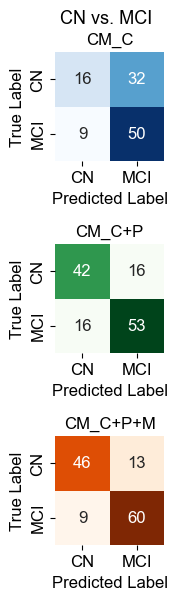

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


class_names = ['CN', 'MCI']

# 要绘制的混淆矩阵
# cm0 = ft0_confusion_matrices[4]
# cm1 = ft1_confusion_matrices[4]
# cm2 = vt_confusion_matrix[4]

cm0 = [[16,32],[9,50]]
cm1 = [[42,16],[16,53]]
cm2 = [[46,13],[9,60]]


# fig, axs = plt.subplots(1, 3, figsize=(6, 2.2))  # (1, 3) 布局
fig, axs = plt.subplots(3, 1, figsize=(1.9, 6.3))  
plt.rcParams.update({'font.family': 'Arial', 'font.size': 12})

# 绘制第一个混淆矩阵
sns.heatmap(cm0, annot=True, fmt='d', cmap='Blues', ax=axs[0], cbar=False, xticklabels=class_names, yticklabels=class_names)
axs[0].set_title('CM_C', fontsize=12)#Confusion Matrix 设置标题位置在左侧   loc='left'
axs[0].set_xlabel('Predicted Label', fontsize=12)
axs[0].set_ylabel('True Label', fontsize=12)
# axs[0].yaxis.set_label_position("right")
# axs[0].yaxis.tick_right()  # 将Y轴刻度也移至右侧


# 绘制第二个混淆矩阵
sns.heatmap(cm1, annot=True, fmt='d', cmap='Greens', ax=axs[1], cbar=False, xticklabels=class_names, yticklabels=class_names) #loc='left'
axs[1].set_title('CM_C+P', fontsize=12)
axs[1].set_xlabel('Predicted Label', fontsize=12)
axs[1].set_ylabel('True Label', fontsize=12)
# axs[1].yaxis.set_label_position("right")

# 绘制第三个混淆矩阵
sns.heatmap(cm2, annot=True, fmt='d', cmap='Oranges', ax=axs[2], cbar=False, xticklabels=class_names, yticklabels=class_names)
axs[2].set_title('CM_C+P+M', fontsize=12)
axs[2].set_xlabel('Predicted Label', fontsize=12)#Predicted Label
axs[2].set_ylabel('True Label', fontsize=12)
# axs[2].yaxis.set_label_position("right")



# 在图的上方添加一行文字
fig.suptitle('CN vs. MCI', fontsize=13, y=0.95,x=0.6)
# 添加旋转的文字
# fig.text(0, 0.5, 'True Label', rotation=90, va='center', ha='center', fontsize=12)

# 自动调整子图布局
plt.tight_layout()

# 显示图形
plt.show()


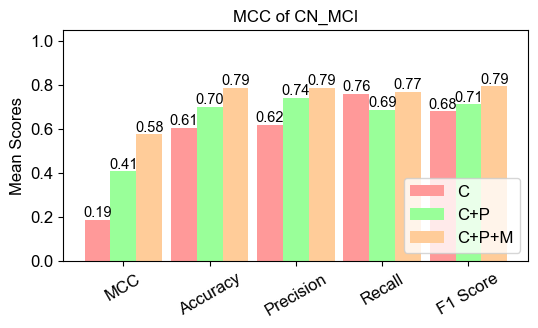

In [211]:
# C 、C+P 和 C+P+M 的结果
results_c = [0.1881, 0.6062, 0.6189, 0.7602, 0.6810]
results_cp = [0.4074, 0.7022, 0.7431, 0.6870, 0.7125]
results_cpm = [0.5758, 0.7859, 0.7859, 0.7681, 0.7936]


# 评价指标
metrics = ['MCC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

# 绘制分组柱状图
plt.figure(figsize=(6,3))
bar_width = 0.3
x = np.arange(len(metrics))

# 绘制 C 的柱状图
bars_c = plt.bar(x - bar_width, results_c, bar_width, color='#FF9999', label='C')

# 绘制 C+P 的柱状图
bars_cp = plt.bar(x , results_cp, bar_width, color='#99FF99', label='C+P')

# 绘制 C+P+M 的柱状图
bars_cpm = plt.bar(x + bar_width, results_cpm, bar_width,color='#FFCC99', label='C+P+M')


# # 添加图表标题和轴标签
plt.title('MCC of CN_MCI', fontsize=12)
plt.xlabel('', fontsize=12)
plt.ylabel('Mean Scores', fontsize=12)

# 设置 x 轴刻度标签
plt.xticks(x, metrics,rotation=30)
plt.ylim(0, 1.05) 

# 添加图例
plt.legend(loc='lower right')

# 在柱状图上添加值
for bars in [bars_c, bars_cp, bars_cpm]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            height, 
            f'{height:.2f}', 
            ha='center', 
            va='bottom', 
            fontsize=10.5
        )

# 显示图形
plt.show()

##### SVM 核融合

In [510]:
# from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
# from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics.pairwise import pairwise_kernels
# from sklearn.pipeline import Pipeline

# ft1 = ['PTGENDER', 'PTMARRY', 'AGE','PTEDUCAT', 'cov_prs']
# ft2 = ['cg17750572', 'cg01452847', 'cg13348062', 'cg18627235', 'cg15452204', 
#        'cg01821149', 'cg00884606', 'cg03354992', 'cg09173768', 'cg14515364']
# X_data = CN_MCI_Data[ft1 + ft2]


# # 定义核函数
# def custom_kernel(X1, X2, kernel1='rbf', kernel2='sigmoid', weight=0.5):
#     # 核函数融合
#     K1 = pairwise_kernels(X1, metric=kernel1)
#     K2 = pairwise_kernels(X2, metric=kernel2)
#     return weight * K1 + (1 - weight) * K2

# # 定义参数搜索范围
# kernel_param_grid = {
#     'kernel1': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'kernel2': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'weight': [0.1, 0.3, 0.5, 0.7, 0.9]
# }

In [511]:
# '''执行网格搜索，寻找最佳kernel融合参数'''

# best_score = 0
# best_params = {}

# # SVM模型，设置不同的核函数
# com_svm = SVC(kernel='precomputed')
# # 遍历所有参数组合
# for kernel1 in kernel_param_grid['kernel1']:
#     for kernel2 in kernel_param_grid['kernel2']:
#         for weight in kernel_param_grid['weight']:
#             # 计算预先计算的核矩阵
#             K = custom_kernel(X_data[ft1], X_data[ft2], kernel1=kernel1, kernel2=kernel2, weight=weight)

#             # 使用预先计算的核矩阵训练模型并评估
#             acc_scores = cross_val_score(com_svm, K, y, cv=5, scoring='accuracy')

#             # 如果当前组合得分更好，则更新最佳参数
#             if np.mean(acc_scores) > best_score:
#                 best_score = np.mean(acc_scores)
#                 best_params = {'kernel1': kernel1, 'kernel2': kernel2, 'weight': weight}

# print(f"最佳参数: {best_params}, 最佳得分: {best_score:.4f}")

最佳参数: {'kernel1': 'poly', 'kernel2': 'poly', 'weight': 0.7}, 最佳得分: 0.6551


In [517]:
# '''使用最佳参数进行五折交叉验证并计算评价指标'''

# kfold = StratifiedKFold(n_splits=5)
# com_metrics = {'AUC': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []}
# conf_matrices = []

# # 计算整体数据的核矩阵
# K_total = custom_kernel(X_data[ft1], X_data[ft2], 
#                         kernel1=best_params['kernel1'], 
#                         kernel2=best_params['kernel2'], 
#                         weight=best_params['weight'])

# # 进行五折交叉验证
# for train_index, test_index in kfold.split(K_total, y):
#     K_train, K_test = K_total[train_index][:, train_index], K_total[test_index][:, train_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # 训练SVM模型
#     model = SVC(kernel='precomputed')
#     model.fit(K_train, y_train)
#     y_pred = model.predict(K_test)

#     # 计算评价指标
#     com_metrics['AUC'].append(roc_auc_score(y_test, y_pred))
#     com_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
#     com_metrics['Precision'].append(precision_score(y_test, y_pred))
#     com_metrics['Recall'].append(recall_score(y_test, y_pred))
#     com_metrics['F1'].append(f1_score(y_test, y_pred))

#     # 生成并保存混淆矩阵
#     conf_matrices.append(confusion_matrix(y_test, y_pred))

# # 输出平均值
# for metric_name, values in com_metrics.items():
#     print(f"{metric_name} 平均值: {np.mean(values):.4f}")

# # 输出混淆矩阵（可以选择输出每个折的混淆矩阵，或者合并后的矩阵）
# print("混淆矩阵:")
# for i, cm in enumerate(conf_matrices):
#     print(f"Fold {i+1}:\n{cm}\n")

# # 计算合并后的混淆矩阵（所有折的结果相加）
# final_cm = np.sum(conf_matrices, axis=0)
# print(f"合并后的混淆矩阵:\n{final_cm}")


AUC 平均值: 0.6184
Accuracy 平均值: 0.6551
Precision 平均值: 0.7049
Recall 平均值: 0.7681
F1 平均值: 0.7345
混淆矩阵:
Fold 1:
[[18 24]
 [16 53]]

Fold 2:
[[17 25]
 [14 55]]

Fold 3:
[[20 22]
 [12 57]]

Fold 4:
[[25 17]
 [15 54]]

Fold 5:
[[18 23]
 [23 46]]

合并后的混淆矩阵:
[[ 98 111]
 [ 80 265]]
